In [1]:
%matplotlib inline

from pixie4e import * # import our python module generated by kaitai struct
import matplotlib.pyplot as plt # plotting modules
import random
import numpy as np # numpy provides useful array manipulations like average, max, etc.

In [2]:
# Opens a handle to read the binary data file
# !!!! Edit the file path to point to your local StilbeneAmCs_500_0253.b00 file !!!!
pixie_data = Pixie4e.from_file(r"C:/Users/canto/Repositories/xia.git/data/StilbeneAmCs_500_0253/StilbeneAmCs_500_0253.b00")

# NOTE - because of how the footer is generated in the file, the schema can't yet switch on the
# event header and read the footer in correctly. As a result the footer gets read in as one extra
# 0-energy event. As such, while looping through we need to avoid the last element in the array of
# events
# for event in pixie_data.events[:-1]:
#     print(event.header.timestamp_full)

In [3]:
psa = []
energies = []

# Populate arrays with the psa and energy values from the binary file
for event in pixie_data.events[:-1]:
    psa.append(event.header.user_psa_value)
    energies.append(event.header.energy)

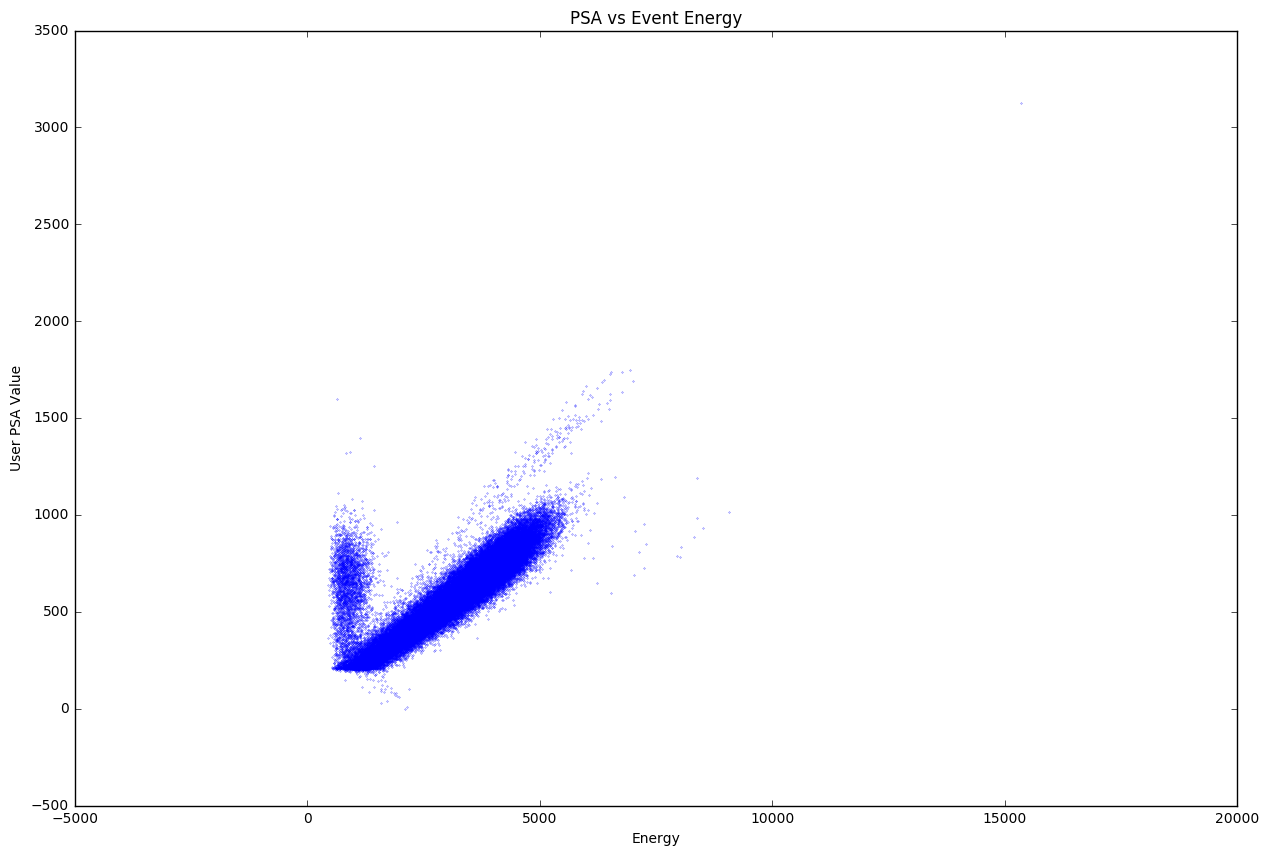

In [4]:
plt.figure(figsize=(15,10))
plt.scatter(energies, psa, marker='o', s=0.05, color='b')
plt.xlabel('Energy')
plt.ylabel('User PSA Value')
plt.title('PSA vs Event Energy')
plt.show()


Event Number: 44356


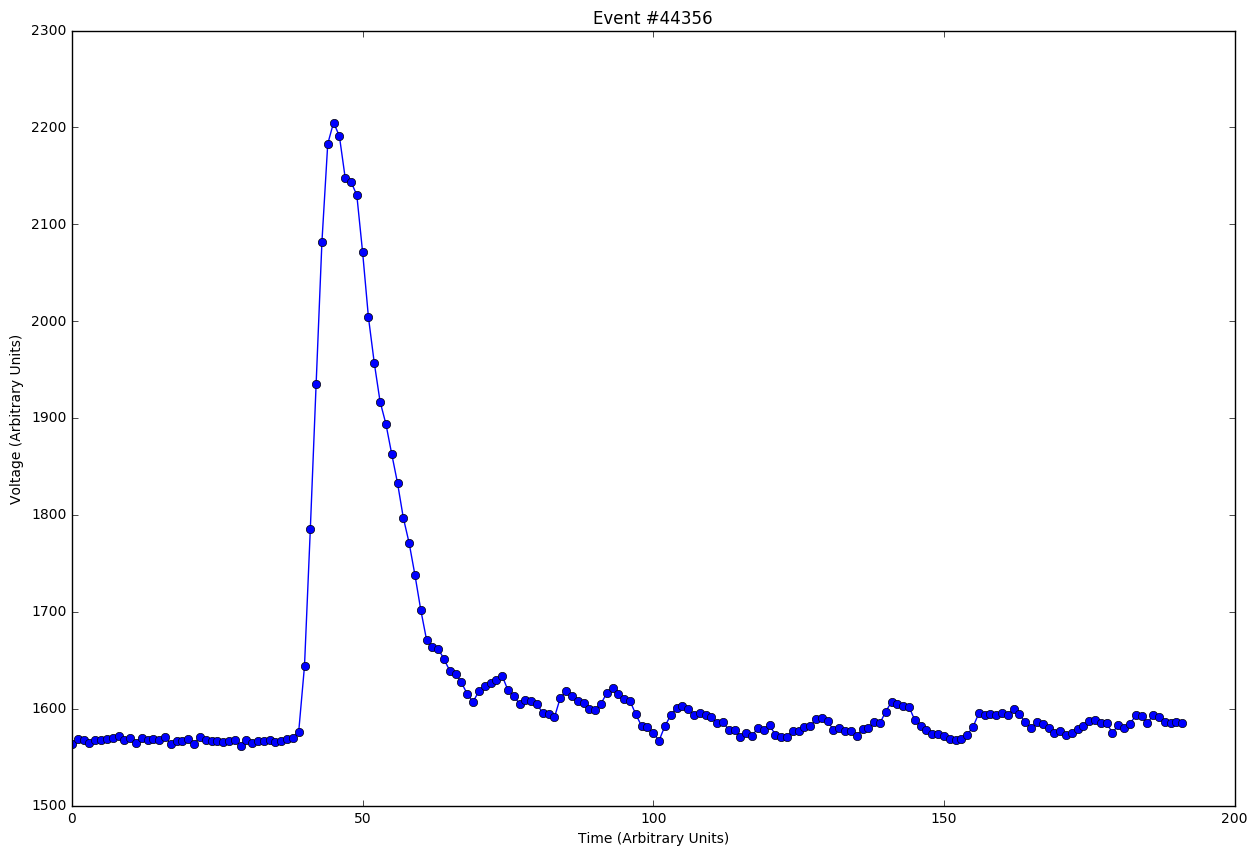

In [37]:
# Plot a random pulse from the file
event_number = random.randint(0, 50000)
print("Event Number: " + str(event_number))
event_random = pixie_data.events[event_number]
pulse = event_random.data
plt.figure(figsize=(15,10))
plt.title("Event #" + str(event_number))
plt.xlabel("Time (Arbitrary Units)")
plt.ylabel("Voltage (Arbitrary Units)")
plt.plot(pulse, '-o')

In [30]:
def get_baseline(trace_data):
    start_idx = 4
    final_idx = start_idx + 8
    
    base = np.average(trace_data[start_idx:final_idx])
    
    return base
    
# not used yet; model for findlevel?
# find 10% level before max, searching back from maximum
# findlevel/q/R=(V_maxloc,0) trace, (base+ampl*RTlow)
# lev10 = V_levelX    //in x units
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    
    return idx

def process_pulse(pulse):
    # get a baseline
    base = get_baseline(pulse)
    #print(base)

    # find the amplitude
    ampl = np.max(pulse) - base
    #print(ampl)
    
    # find the integral
    integral = np.sum(pulse - base)

    # calculate Q1Sum
    # need to be able to find index associated with 10% max amplitude
    # for a good Q1start, Q0start
    Q1start = np.argmax(pulse)
    start_idx = Q1start + SoQ1
    final_idx = Q1start + SoQ1 + LoQ1

    Q1Sum = np.sum(pulse[start_idx:final_idx] - base)
    #print(Q1Sum)

    # calculate Q0Sum
    Q1start = np.argmax(pulse)
    start_idx = Q1start + SoQ0
    final_idx = Q1start + SoQ0 + LoQ0

    Q0Sum = np.sum(pulse[start_idx:final_idx] - base)
    
    return ampl, integral

In [31]:
# this is Amy exploring the data structure
#print (np.shape(pixie_data.events))
#print (type(pixie_data))

# these are indices, currently unused
SoQ0 = 10
LoQ0 = 20
SoQ1 = 100
LoQ1 = 5

# get the amplitudes and integrals for each event
ampl_arr = np.zeros(np.size(pixie_data.events[:-1]))
integral_arr = np.zeros(np.size(pixie_data.events[:-1]))
for idx, event in enumerate(pixie_data.events[:-1]):
    pulse = event.data
    
    ampl, integral = process_pulse(pulse)
    
    ampl_arr[idx] = ampl
    integral_arr[idx] = integral

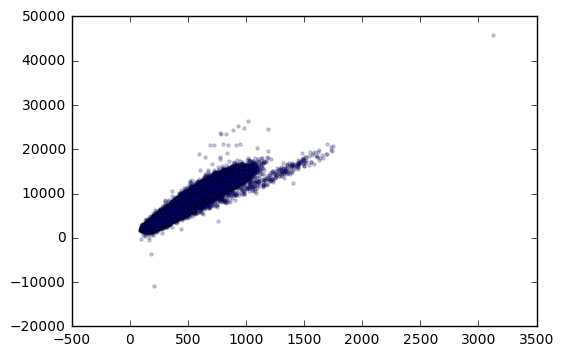

In [36]:
plt.scatter(ampl_arr, integral_arr, marker='.', alpha=0.2)